In [401]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [402]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [403]:
DATASET_PATH = './train.csv'
DATASET_TEST = './test.csv'

In [404]:
df = pd.read_csv(DATASET_PATH, sep=',')
df_test = pd.read_csv(DATASET_TEST, sep=',')

# Уменьшение объема памяти датасета

In [405]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col]. astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                       
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                       df[col] = df[col].astype(np.float32)
                else:
                       df[col] = df[col].astype(np.float64)

    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:1f}%'.format(100 * (start_mem - end_mem) / start_mem))
                       
    return df

In [406]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 54.995600%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


# Визуализация данных

In [407]:
matplotlib.rcParams.update({'font.size': 14}) # размер шрифта на всех графиках

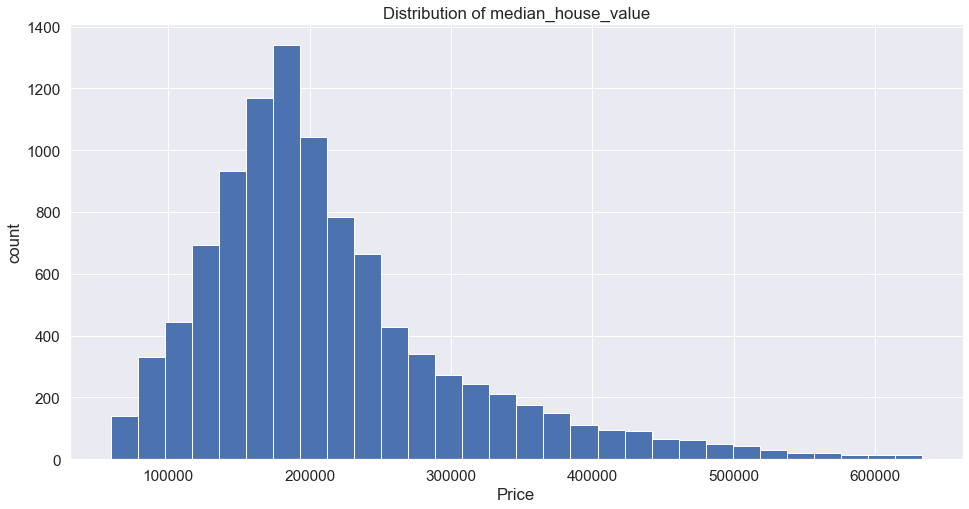

In [408]:
plt.figure(figsize=(16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of median_house_value')
plt.show()

### Анализ признаков

In [409]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [410]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN


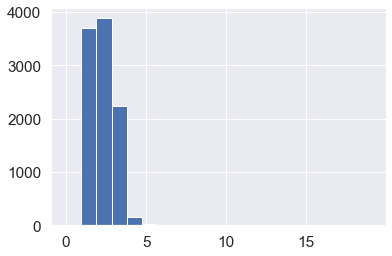

In [411]:
df['Rooms'].hist(bins=20)
plt.show()

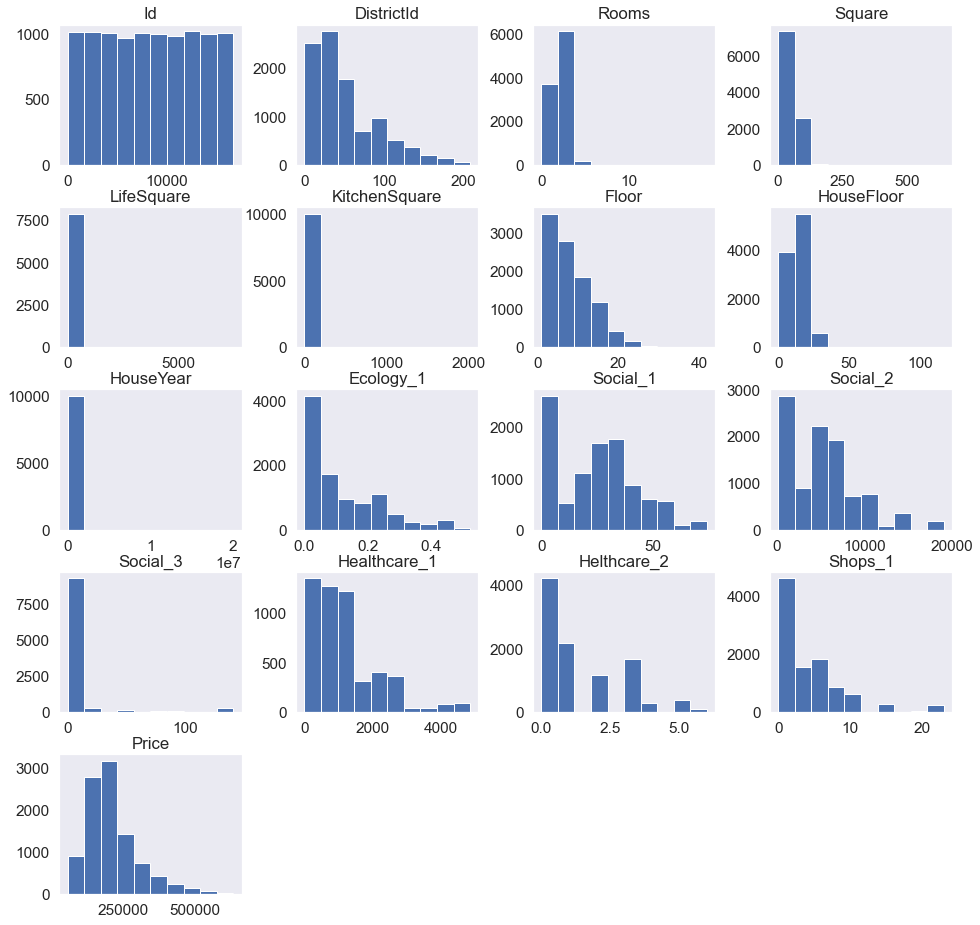

In [412]:
df.hist(figsize=(16, 16), bins=10, grid=False)
plt.show()

In [417]:
df.groupby(['Rooms']).first()

,Id,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Rooms,,,,,,,,,,,,,,,,,,,
0.0,3159,88,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,1183.0,3,9,B,158998.109375
1.0,3013,22,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2.0,13866,94,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,176.0,0,6,B,343995.093750
3.0,11809,27,115.027313,47.671970,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,240.0,0,0,B,305018.875000
4.0,3876,100,104.769020,79.316650,8.0,4,8.0,1960,0.200147,B,B,23,3975,8,770.0,2,0,B,600903.812500
5.0,13434,13,183.382278,100.985504,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,1084.0,5,15,B,622888.812500
6.0,14003,99,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750
10.0,5927,57,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,30.0,5,15,B,317265.312500
19.0,8491,1,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188


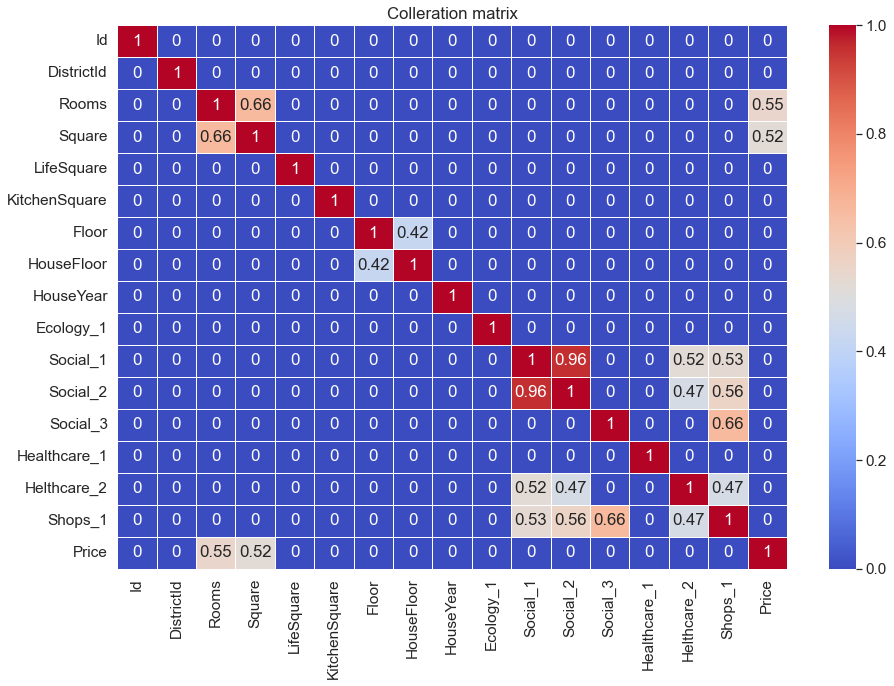

In [373]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')

plt.title('Colleration matrix')
plt.show()

### Предобработка данных и Feature engineering

In [374]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.binary_to_numbers = None
        self.housefloor_max_value = None
        self.house_year_min_value = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.kitchen_max_value = None
        self.kitchen_min_value = None
        self.LifeSquare_Square = None
        self.square_max_value = None
        self.square_min_value = None
        self.lifesquare_max_value = None
        self.lifesquare_min_value = None
        
    def fit(self, df):
        
        # Расчет медиан
        
        self.medians = df.median()
        
        # binary_to_numbers
        
        self.binary_to_numbers = {'A': 1, 'B': 0}
        
        # Отношение медианы жилой площади к Общей площади для вычисления замены пропусков
        
        self.LifeSquare_Square = (self.medians['LifeSquare'] / self.medians['Square'])
        
        # Максимальные и минимальные значения признаков
        
        self.square_max_value = 600
        self.square_min_value = 10
        
        
        self.lifesquare_max_value = np.quantile(df['LifeSquare'], q=.975)
        self.lifesquare_min_value = 5
        
        self.housefloor_max_value = 90
        self.house_year_min_value = datetime.now().year - 100
        
        self.kitchen_max_value = np.quantile(df['KitchenSquare'], q=.975)
        self.kitchen_min_value = 3
        
        
    def transform(self, df):
        """Трансформация данных"""
        
    # 1. Пропуски
    
        df['LifeSquare_nan'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        df['LifeSquare'].fillna((self.LifeSquare_Square * df['Square']), inplace=True)
        
        df['Healthcare_1_nan'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        df['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
    # 2. Исключение ненужных столбцов
    
        df['Id'] = df['Id'].astype('str')
        
        
    # 3. Выбросы (outliers)

        
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 5), 'Rooms_outlier'] = 1
        df.loc[(df['Rooms'] == 0), 'Rooms'] = 1
        df.loc[(df['Rooms'] > 5), 'Rooms'] = 5
            
        # Square
        
        df['Square_outlier'] = 0
        df.loc[(df['Square'] > self.square_max_value) | (df['Square'] <= self.square_min_value), 'Square_outlier'] = 1
        df.loc[(df['Square'] > self.square_max_value), 'Square'] = self.square_max_value
        df.loc[(df['Square'] <= self.square_min_value), 'Square'] = self.square_min_value
        
        df['Square'].fillna(self.medians['Square'], inplace=True)

        # KitchenSquare
        condition = (df['KitchenSquare'] > self.kitchen_max_value) | (df['KitchenSquare'] < self.kitchen_min_value)
        df['KitchenSquare_outlier'] = 0
        df.loc[condition, 'KitchenSquare_outlier'] = 1
        df.loc[(df['KitchenSquare'] < self.kitchen_min_value), 'KitchenSquare'] = self.kitchen_min_value
        df.loc[(df['KitchenSquare'] > self.kitchen_max_value), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        df['KitchenSquare'].fillna(self.medians['KitchenSquare'], inplace=True)

        # LifeSquare
        condition = (df['LifeSquare'] < self.lifesquare_min_value) |\
            (df['LifeSquare'] >= (df['Square'] - df['KitchenSquare'])) |\
            (df['LifeSquare'] > self.lifesquare_max_value)
        df['LifeSquare_outlier'] = 0
        df.loc[condition, 'LifeSquare_outlier'] = 1
        df.loc[condition, 'LifeSquare'] = self.LifeSquare_Square * df['Square'] - df['KitchenSquare']
        
        df['LifeSquare'].fillna(self.LifeSquare_Square * df['Square'], inplace=True)

        # HouseFloor
        condition = (df['HouseFloor'] < 1) | (df['HouseFloor'] > self.housefloor_max_value)
        df['HouseFloor_outlier'] = 0
        df.loc[condition, 'HouseFloor_outlier'] = 1
        df.loc[df['HouseFloor'] < 1, 'HouseFloor'] = 1
        df.loc[df['HouseFloor'] > self.housefloor_max_value, 'HouseFloor'] = self.medians['HouseFloor']
        
        df['HouseFloor'].fillna(self.medians['HouseFloor'], inplace=True)

        # Floor
        df['Floor_outlier'] = 0
        df.loc[(df['HouseFloor'] < df['Floor']) | (df['Floor'] < 1), 'Floor_outlier'] = 1
        df.loc[(df['HouseFloor'] < df['Floor']), 'Floor']  = df['HouseFloor']
        df.loc[(df['Floor'] < 1), 'Floor'] = 0
        
        df['Floor'].fillna(self.medians['Floor'], inplace=True)
        
        # HouseYear
        current_year = datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[(df['HouseYear'] > current_year) | (df['HouseYear'] < self.house_year_min_value), 'HouseYear_outlier'] = 1
        df.loc[(df['HouseYear'] > current_year), 'HouseYear'] = current_year
        df.loc[(df['HouseYear'] < self.house_year_min_value), 'HouseYear'] = self.house_year_min_value
        
        df['HouseYear'].fillna(self.medians['HouseYear'], inplace=True)

        
    # 4. Изменение типа
        
         # Ecology_2
        df['Ecology_2'] = df['Ecology_2'].replace(self.binary_to_numbers)   
        
        # Shops_2
        df['Shops_2'] = df['Shops_2'].replace(self.binary_to_numbers)

        # Ecology_3
        df['Ecology_3'] = df['Ecology_3'].replace(self.binary_to_numbers)
        
    # 5. Новые фичи (features)
        
        scaler = RobustScaler()
        
        pca = PCA(n_components=1, random_state=22)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        pca = PCA(n_components=1, random_state=22)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Ecology_1', 'Ecology_2', 'Ecology_3']]))
        df['Ecology'] = pca.fit_transform(social_scaled)
        
        pca = PCA(n_components=1, random_state=22)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Shops_1', 'Shops_2']]))
        df['Ecology'] = pca.fit_transform(social_scaled)
        
        #house_age
        current_year = datetime.now().year
        df['house_age'] = current_year - X['HouseYear']

        return df
             

In [375]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
                
        # Target encoding
        ## District, Rooms
        df = X.copy()


        
    def transform(self, X):
        
        # Категоризация применение
        X = self.age_to_cat(X)
        X = self.floor_to_cat(X)


        # Отношение LifeSquare/Square
        X['LifeSquare/Square'] = (X['LifeSquare'] / X['Square'])
        
        # Отношение Rooms/Square
        X['Square/Rooms'] = (X['Square'] / X['Rooms'])

        # Нежилая площадь
        X['NonresidentialSquare'] = X['Square'] - X['LifeSquare'] - X['KitchenSquare']
        
        
        
        return X
         
    # Категоризация этажности

    def floor_to_cat(self, X):

        X['floor_cat'] = 0

        X.loc[(X['Floor'] == 1), 'floor_cat'] = 1
        X.loc[(X['Floor'] >= 2) & (X['Floor'] < 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] >= 5) & (X['Floor'] < 10), 'floor_cat'] = 3
        X.loc[(X['Floor'] >= 10) & (X['Floor'] < 15), 'floor_cat'] = 4
        X.loc[(X['Floor'] >= 15) & (X['Floor'] < 25), 'floor_cat'] = 5
        X.loc[(X['Floor'] >= 25), 'floor_cat'] = 6

        return X


    def age_to_cat(self, X):

        X['age_cat'] = 0

        X.loc[X['house_age'] <= 5, 'age_cat'] = 1
        X.loc[(X['house_age'] > 5) & (X['house_age'] <= 10), 'age_cat'] = 2
        X.loc[(X['house_age'] > 10) & (X['house_age'] <= 15), 'age_cat'] = 3
        X.loc[(X['house_age'] > 15) & (X['house_age'] <= 25), 'age_cat'] = 4
        X.loc[(X['house_age'] > 25) & (X['house_age'] <= 40), 'age_cat'] = 5
        X.loc[(X['house_age'] > 40) & (X['house_age'] <= 45), 'age_cat'] = 6
        X.loc[(X['house_age'] > 45) & (X['house_age'] <= 55), 'age_cat'] = 7
        X.loc[(X['house_age'] > 55), 'age_cat'] = 8

        return X


### Разделение данных

In [376]:
X = df.drop(columns='Price')

In [377]:
y = df['Price']

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

In [379]:
pipe = DataPipeline()
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

X_train.isna().sum().sum(), X_test.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [380]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_test = features_gen.transform(X_test)
df_test = features_gen.transform(df_test)

X_train.shape, X_test.shape, df_test.shape

((6700, 36), (3300, 36), (5000, 36))

In [381]:
pd.set_option('display.max_columns', None)

In [382]:
X_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social,Ecology,house_age,age_cat,floor_cat,LifeSquare/Square,Square/Rooms,NonresidentialSquare
8511,5355,74,1.0,53.865501,30.633324,3.0,1.0,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,1,0,-1.035149,-0.440351,44,6,1,0.568700,53.865501,20.232178
1449,11764,93,3.0,169.117203,105.595856,3.0,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,1,1,0,0,1,0,0,1,0,-1.638467,-0.839937,44,6,2,0.624395,56.372402,60.521347
2965,15528,66,3.0,79.489578,47.728355,12.0,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,-0.007235,-0.240557,20,4,5,0.600435,26.496527,19.761223
9497,10578,22,2.0,45.578159,28.475996,5.0,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,-1.422149,-0.839937,59,8,2,0.624773,22.789080,12.102163
5488,1490,31,1.0,35.803776,20.454700,6.0,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,0.377333,-0.640144,47,7,1,0.571300,35.803776,9.349075


In [383]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 8511 to 5640
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     6700 non-null   object 
 1   DistrictId             6700 non-null   int16  
 2   Rooms                  6700 non-null   float32
 3   Square                 6700 non-null   float32
 4   LifeSquare             6700 non-null   float32
 5   KitchenSquare          6700 non-null   float32
 6   Floor                  6700 non-null   float32
 7   HouseFloor             6700 non-null   float32
 8   HouseYear              6700 non-null   int32  
 9   Ecology_1              6700 non-null   float32
 10  Ecology_2              6700 non-null   int64  
 11  Ecology_3              6700 non-null   int64  
 12  Social_1               6700 non-null   int8   
 13  Social_2               6700 non-null   int16  
 14  Social_3               6700 non-null   int16  
 15  H

In [384]:
feature_names_for_stand = X_train.select_dtypes(include=['float64','float32', 'float16', 'int64', 'int32', 'int16', 'int8']).columns

target_name = 'Price'

In [385]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

### Построение модели

In [386]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [387]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social,Ecology,house_age,age_cat,floor_cat,LifeSquare/Square,Square/Rooms,NonresidentialSquare
8511,5355,74,1.0,53.865501,30.633324,3.0,1.0,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,1,0,-1.035149,-0.440351,44,6,1,0.568700,53.865501,20.232178
1449,11764,93,3.0,169.117203,105.595856,3.0,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,1,1,0,0,1,0,0,1,0,-1.638467,-0.839937,44,6,2,0.624395,56.372402,60.521347
2965,15528,66,3.0,79.489578,47.728355,12.0,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,-0.007235,-0.240557,20,4,5,0.600435,26.496527,19.761223
9497,10578,22,2.0,45.578159,28.475996,5.0,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,-1.422149,-0.839937,59,8,2,0.624773,22.789080,12.102163
5488,1490,31,1.0,35.803776,20.454700,6.0,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,0.377333,-0.640144,47,7,1,0.571300,35.803776,9.349075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,11821,27,1.0,41.674965,26.021620,3.0,14.0,19.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,1,1,0,0,1,0,0,0,0,-1.633772,-0.640144,44,6,4,0.624395,41.674965,12.653345
79,2286,99,2.0,47.304764,28.737215,6.0,9.0,9.0,1972,0.012339,0,0,35,5776,1,2078.0,2,4,0,0,0,0,0,0,0,0,0,0,-1.422364,-0.040764,49,7,3,0.607491,23.652382,12.567549
8039,16726,119,2.0,51.313702,32.964130,6.0,9.0,9.0,1973,0.333892,0,0,30,6564,1,900.0,0,0,0,0,1,0,0,0,0,0,1,0,-1.421418,-0.839937,48,7,3,0.642404,25.656851,12.349571
6936,15625,34,3.0,89.665611,52.986717,3.0,19.0,25.0,2016,0.069753,0,0,53,13670,4,900.0,1,11,0,0,1,0,0,1,1,0,0,0,-0.803842,1.357789,5,1,5,0.590937,29.888536,33.678894


In [388]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=5,
                                     random_state=42,  
                                     n_estimators=150)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)

Train R2:	0.8908
Test R2:	0.7295


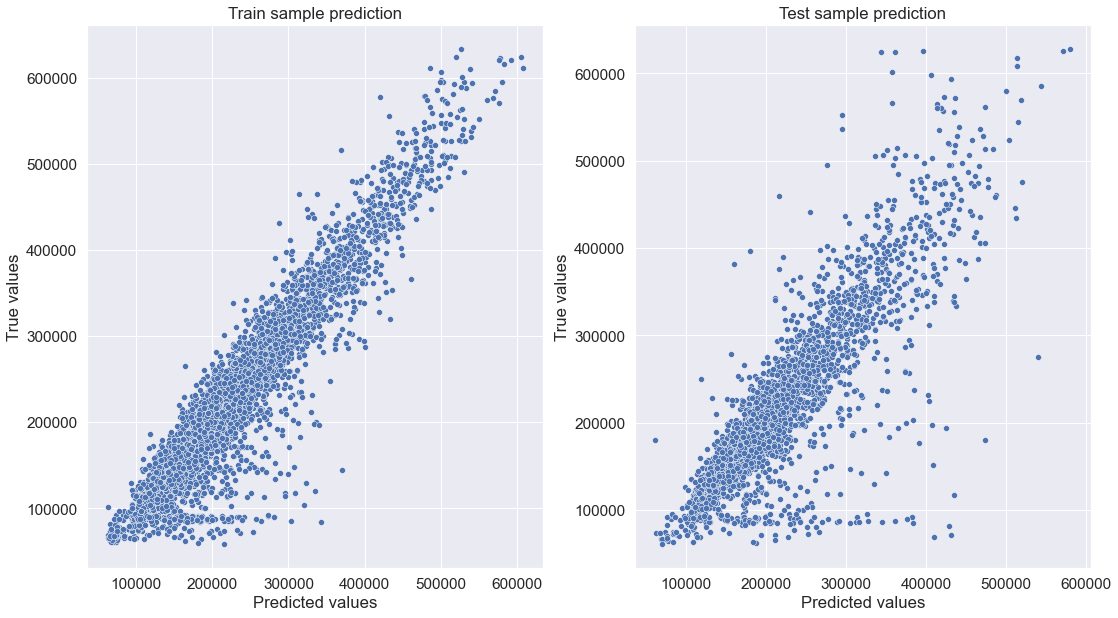

In [389]:
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Настройка и оценка финальной модели

#### Кросс-валидация

In [390]:
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

In [391]:
# np.round(cv_score.mean(), 4)

In [392]:
# %%time
# params = {'n_estimators':[150, 200, 250],
#          'max_depth':[4, 5, 6],
#          'min_samples_leaf':[5, 8, 10, 15, 22]}

# gs = GridSearchCV(gb_model, params,
#                   scoring='r2',
#                   cv=KFold(n_splits=5,
#                           random_state=21,
#                           shuffle=True),
#                   n_jobs=-1
#                  )
# gs.fit(X_train, y_train)
                  

In [393]:
# gs.best_params_

In [394]:
# gs.best_score_

#### Обучение и оценка модели

In [395]:
final_model = GradientBoostingRegressor(criterion='mse',
                                       max_depth=5,
                                       min_samples_leaf=35,
                                       random_state=22,
                                       n_estimators=150)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=35,
                          n_estimators=150, random_state=22)

Train R2:	0.844
Test R2:	0.7345


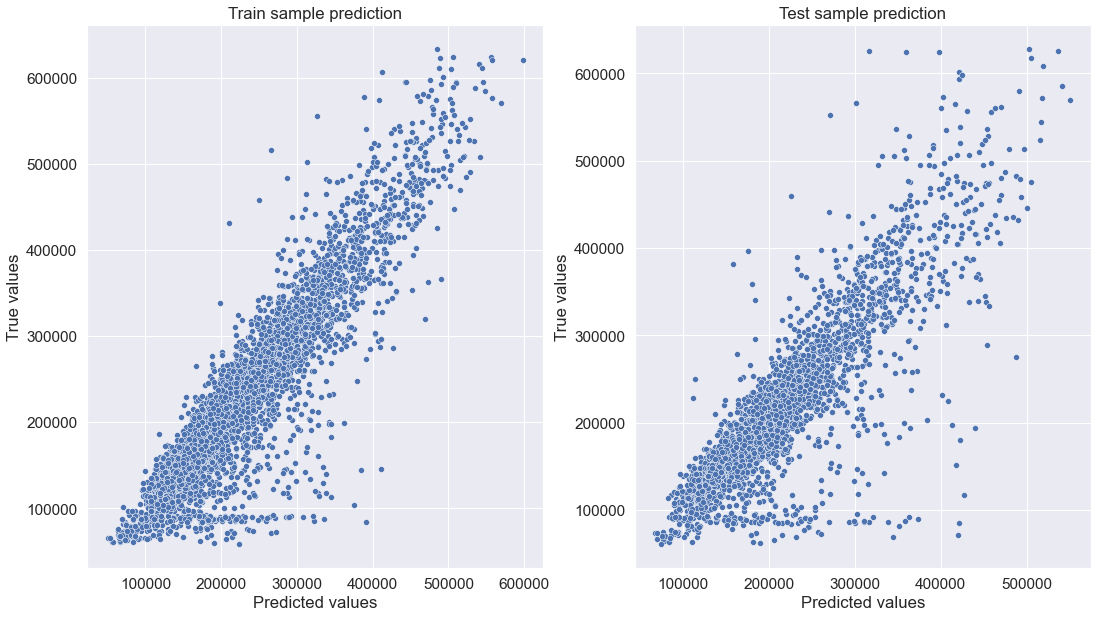

In [396]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Анализ прогнозов

In [397]:
final_model.feature_importances_

array([4.03481908e-03, 5.58898823e-02, 7.58355725e-02, 4.12822295e-01,
       9.35333947e-03, 1.15493815e-02, 5.68082379e-03, 1.35221072e-02,
       1.32486799e-02, 4.28722402e-02, 0.00000000e+00, 1.58093893e-04,
       9.68816459e-02, 8.93556130e-02, 1.85780958e-02, 1.20498416e-02,
       1.66950663e-03, 4.93073453e-03, 9.01260487e-05, 2.04951952e-04,
       1.91119587e-03, 0.00000000e+00, 0.00000000e+00, 2.44548207e-03,
       2.28960137e-04, 0.00000000e+00, 2.24709762e-04, 0.00000000e+00,
       6.57407935e-02, 7.76987824e-03, 1.20654042e-02, 1.95612946e-03,
       1.11202175e-03, 9.59505567e-03, 1.18311802e-02, 1.63914383e-02])

In [398]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [399]:
feature_importances

,feature_name,importance
3,Square,0.412822
12,Social_1,0.096882
13,Social_2,0.089356
2,Rooms,0.075836
28,Social,0.065741
1,DistrictId,0.055890
9,Ecology_1,0.042872
14,Social_3,0.018578
35,NonresidentialSquare,0.016391
7,HouseFloor,0.013522


### Сохранение модели

In [400]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

NameError: name 'MODEL_FILE_PATH' is not defined

In [ ]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

Kaggle

In [ ]:
df_test.head()

In [ ]:
test_preds = final_model.predict(df_test)

In [ ]:
submission = pd.DataFrame(df_test['Id'])
submission['Price'] = pd.DataFrame(test_preds)
submission

In [ ]:
submission.set_index('Id', inplace=True)

In [ ]:
submission.describe()

In [ ]:
submission.to_csv('./submission.csv', sep=',')